# Modele de réseau neuronale

Toutes les étapes pour arriver à un modele correct

## Imports

In [66]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
#import seaborn as sns #On ne sait jamais que ça serve
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler #Normalisation #Il faut l'installer aussi avec conda install
import random
from math import ceil


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import  Dense, Conv3D, BatchNormalization,MaxPooling3D, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard


#conda install pydot
#conda install pydotplus
#conda install graphviz
from tensorflow.keras.utils import plot_model
#import pydot


import threading
from queue import Queue, Empty
from time import sleep, time

### Paramètres généraux

In [67]:
nb_classes = 10 #Nombre de classes
fps = 10
size = (100,75) #(40,30)
#Parametres du generator
pack_size = 50
batch_size = 10
epochs = 2 #20
learning_rate = 0.001

In [68]:
#Verification qu'un modele avec ces paramètres n'existe pas déjà
folder = 'Saved_model'
modele_type = 'model_convLSTM2D'
param = f"_{fps}_{size[1]}_{size[0]}_{nb_classes}_{epochs}_{batch_size}_{pack_size}_{int(learning_rate*1000)}mili"
full_name = folder + '\\' + modele_type + param
print(full_name)

Saved_model\model_convLSTM2D_10_75_100_10_2_10_50_1mili


In [69]:
try:
    model_saved = keras.models.load_model(full_name + ".h5")
    print("Pas besoin d'aller plus loin, le modele a déjà été fabriqué")
    model_charge = True
except:
    print("Modele non testé")
    model_charge = False
    #Enregistrement sur Tensorboard
    #tensorboard = TensorBoard(log_dir='Saved_model\\logs\\{}'.format(full_name),)
    #Il faut ouvrir la commande dans le dossier Saved_model et taper:
    #tensorboard --logdir = logs/
    #Ensuite un browser s'ouvre, et sinon on a une URL à mettre dessus
    

Modele non testé


## Fonctions d'imports et preprocess

#### Import

In [70]:
def get_mov_imgs_from_path(path,fps = -1,color = 'gray'):
    '''
    Retourne une liste d'images pour une vidéo. La liste d'image a le nombre de fps voulu
    reprend que le mouvement
    '''
    
    cap = cv2.VideoCapture(path)
    fps_actu = cap.get(cv2.CAP_PROP_FPS)
#     print(f"Traitement de la video n° {path}       ",end="\r")
    if fps <= -1: fps = fps_actu #Je peux ne pas donner de fps et ça va prendre le nombre d'fps initial
    ecart_voulu = int(1000/fps)
    ecart_initial = int(1000/fps_actu)
    imgs = []
    
    ret, frame = cap.read()
    while(cap.isOpened()):
        prev = frame
        ret, frame = cap.read()
       
 
        
        if ret: #Sinon ça plante quand il n'y a plus d'images
            #Récupère seulement certaines images
            t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            modulo = t_ms % ecart_voulu
            if modulo < ecart_initial:
                #Isoler les images
                
                if color == 'gray':
                    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                    prev_gray = cv2.cvtColor(prev,cv2.COLOR_BGR2GRAY)
                    diff_gray = cv2.absdiff(gray,prev_gray)
                    
                elif color == 'rgb':
                    diff_gray = cv2.absdiff(frame,prev) 

                    
                #Première normalisation (elle n'est peut-être pas obligatoire)
                max_ = np.max(diff_gray)
                if max_ == 0:
                    max_ = 1
                ratio = 255.0 / max_
                diff_gray = diff_gray * ratio
                
                
                #On va travailler avec des images en nuance de gris, c'est bcp plus simple
                imgs.append(diff_gray)
            
        else: #Va jusqu'au bout de la vidéo
            break
    else:
        print("Le fichier n'a pas pu être ouvert")
    cap.release()
    
    return imgs

#### Resize

In [71]:
def resize_imgs(imgs,nsize):
    '''
    Change la taille de l'image.
    Le premier élément de nsize est la longueur (width), le deuxième la hauteur (height)
    '''
    return [cv2.resize(img, dsize=nsize, interpolation=cv2.INTER_CUBIC) for img in imgs]

#### Normalisation

In [72]:
def scale_by_pixels(img, x_min, x_max):
    '''
    Scale une image entre 0 et 1.
    Méthode pas efficace mais fonctionnelle contrairement à d'autres méthodes 
    qui faisaient lignes par lignes ce qui causait des erreurs 
    dans le résultat (lignes dans l'image)
    '''
    new_img = img.copy()
    p_min = 1000
    p_max = -1000
    for line in img:
        for pixel in line:
            p_min = min(p_min,pixel)
            p_max = max(p_max,pixel)
    
    #p_min et p_max sont les min et max totaux de mon image
    for l, line in enumerate(img):
        for p,pixel in enumerate(line):
            nom = (pixel - p_min)*(x_max - x_min)
            denom = (p_max - p_min)
            if denom == 0: denom = 1
            new_img[l][p] = x_min + nom/denom
    return new_img

In [73]:
def normalize_imgs(imgs):
    '''
    Normalise une série d'images
    '''
    norm_imgs = []
    for img in imgs:
        norm_img = scale_by_pixels(img,0,1)
        norm_imgs.append(norm_img)
#     print(f"Après normalisation, max = {np.max(norm_imgs)} et min = {np.min(norm_imgs)}")
    return norm_imgs

## Fonction de générateur

In [74]:
def my_gen(labels_list, folder_path, pack_size = 10, pointer = 0, fps = 5, size = (160,120)):
    '''
    à partir de la liste des labels et de la position du foler
    Retourne:
    -une liste d'images de vidéos de shape (pack_size,n_frames,height,width[,channels])
        n_frames = fps*2.4
    -Une liste de numérique avec les labels correspondant aux images (de len = batch_size)
    -Un pointer qui permet de faire tourner my_gen à nouveau et recevoir les éléments suivants de la liste
    
    
    Normalement on peut envoyer X et y_num dans le modele directement (avec fit ou train_on_batch, les deux devraient fonctionner)
    Je vais essayer de travailler avec des thread pour avoir un thread en Train et un trhead en gen
    '''
    #Affiche combien de paquets il faudra
    len_label = len(labels_list)
    if pointer == 0:
        #Uniquement le premier passage
        nb_pack = ceil(len_label/pack_size)
        print(f"Il y aura {nb_pack} packs de {pack_size} vidéos à importer")
    else:
        print(f"Il reste encore {len_label - pointer} vidéos à importer")
    
    y_num = []
    X = []
    for i in range(pointer, pack_size + pointer):
        pointer = i+1
        if i >= len_label:
            break
        label, video_name = labels_list[i]
        
        #Label en numérique
        y_num.append(labels_n[label])
        
        #Preprocess d'images
        file_path = folder_path + "\\" + video_name
        imgs_of_video = get_mov_imgs_from_path(file_path,fps,'gray') #Gray ou rgb
        resized_imgs = resize_imgs(imgs_of_video, size)
        norm_imgs = normalize_imgs(resized_imgs)
        
        X.append(norm_imgs)
        
    print() #Pour ne pas écrire sur la même ligne qu'avant
    X = np.array(X)
    y = np.array(y_num)
    
    #Ajouter une dimsension en à la fin est nécessaire pour certains modèle
    #Commenter cette ligne si ce n'est pas nécessaire
    X = np.expand_dims(X, axis=len(X.shape)) 
    
    # Si le modele est compile avec :loss='sparse_categorical_crossentropy'
    # Il faut un y catégorique , faire ça hors de la fonction
    #y = to_categorical(y, num_classes = nb_classes)

    return (X, y, pointer)

In [75]:
def gen_thread(labels_list, folder_path, pack_size = 10, fps = 5, size = (160,120)):
    '''
    S'assure que my_gen tourne toujours en parallèle du fit. Il prépare toujours 2 paquets de vidéo en avance
    '''
    pointer = 0
    while pointer < len(labels_list):
        X,y,pointer = my_gen(labels_list, folder_path, pack_size, pointer, fps, size)
        q.put((X,y))
        print(f"Pack of {pack_size} videos put in queue")

## Fabrication des modeles

#### Imports

In [76]:
from tensorflow.keras.applications import InceptionV3

In [77]:
#inception_model = InceptionV3(weights='imagenet')

In [78]:
#inception_model.summary()

In [79]:
#plot_model(inception_model, show_shapes=True, show_layer_names=True)

In [80]:
def create_simpler_model(n_frames = 24, height = 120, width = 160, channels = 1, nb_classes = 10):
    
    sample_shape = (n_frames,height,width,channels) #width = 160, height = 120, nframes = 24, 3 channels si on est en RGB (si on est en gris on sait pas)
    
    model = Sequential()
    
    model.add(Conv3D(512, strides =(1,1,1), padding="same", kernel_size=(5, 5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape,data_format='channels_last'))    
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(MaxPooling3D(pool_size=(3,3, 3),data_format = 'channels_first'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(MaxPooling3D(pool_size=(1,3, 3)))
    model.add(Dropout(0.4))

    model.add(Conv3D(128, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.1))



    #LSTM
    
    model.add(ConvLSTM2D(filters = 64,kernel_size = (5,5),activation="tanh", recurrent_activation="sigmoid",return_sequences = True))
    model.add(ConvLSTM2D(filters = 64,kernel_size = (3,3),activation="tanh", recurrent_activation="sigmoid",return_sequences = True))
    model.add(layers.Reshape((24,640)))
    model.add(LSTM(units = 48,activation="tanh", recurrent_activation="sigmoid",return_sequences = False))
    #model.add(ConvLSTM2D(filters = 64,kernel_size = (1,1),activation="tanh", recurrent_activation="sigmoid",return_sequences = False))
    

    #softmax
    model.add(Dense(nb_classes, activation='softmax'))

    return model

In [81]:
def create_model(n_frames = 24, height = 120, width = 160, channels = 1, nb_classes = 10):
    
    sample_shape = (n_frames,height,width,channels) #width = 160, height = 120, nframes = 24, 3 channels si on est en RGB (si on est en gris on sait pas)
    
    model = Sequential()
    
    #model.add(Conv3D(128, strides =(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape,data_format='channels_first'))
    model.add(Conv3D(128, strides =(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape,data_format='channels_last'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Conv3D(64, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), data_format = 'channels_first'))
    model.add(Dropout(0.4))

    model.add(Conv3D(48, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(48, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Conv3D(32, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), data_format = 'channels_first'))
    model.add(Dropout(0.4))

    model.add(Conv3D(16, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Conv3D(8, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(MaxPooling3D(pool_size=(2,2, 2), data_format = 'channels_first')) #Je ne veux pas diviser le nombre d'images cette fois-ci
    model.add(Dropout(0.4))

    model.add(Conv3D(8, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization(center=True, scale=True))



    #LSTM
    
    model.add(ConvLSTM2D(filters = 32,kernel_size = (2,2),activation="tanh", recurrent_activation="sigmoid",return_sequences = True))
    model.add(ConvLSTM2D(filters = 16,kernel_size = (2,2),activation="tanh", recurrent_activation="sigmoid",return_sequences = True))
    model.add(layers.Reshape((19,1408)))
    model.add(LSTM(units = 16,activation="tanh", recurrent_activation="sigmoid",return_sequences = False))
    #model.add(ConvLSTM2D(filters = 64,kernel_size = (1,1),activation="tanh", recurrent_activation="sigmoid",return_sequences = False))
    

    #softmax
    model.add(Dense(nb_classes, activation='softmax'))

    return model

In [82]:
n_frames = int(fps*2.4)

if model_charge:
    print('Modele chargé')
    model = model_saved
else:
    print("Pas de modele chargé, il faut en créer un nouveau")
    #model = create_model(n_frames = n_frames, height = size[1], width = size[0], nb_classes = nb_classes)
    model = create_simpler_model(n_frames = n_frames, height = size[1], width = size[0], nb_classes = nb_classes)

Pas de modele chargé, il faut en créer un nouveau


In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 24, 75, 100, 512)  64512     
_________________________________________________________________
dense_5 (Dense)              (None, 24, 75, 100, 256)  131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 75, 100, 256)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 24, 25, 33, 85)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 25, 33, 85)    340       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 24, 8, 11, 85)     0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 8, 11, 85)    

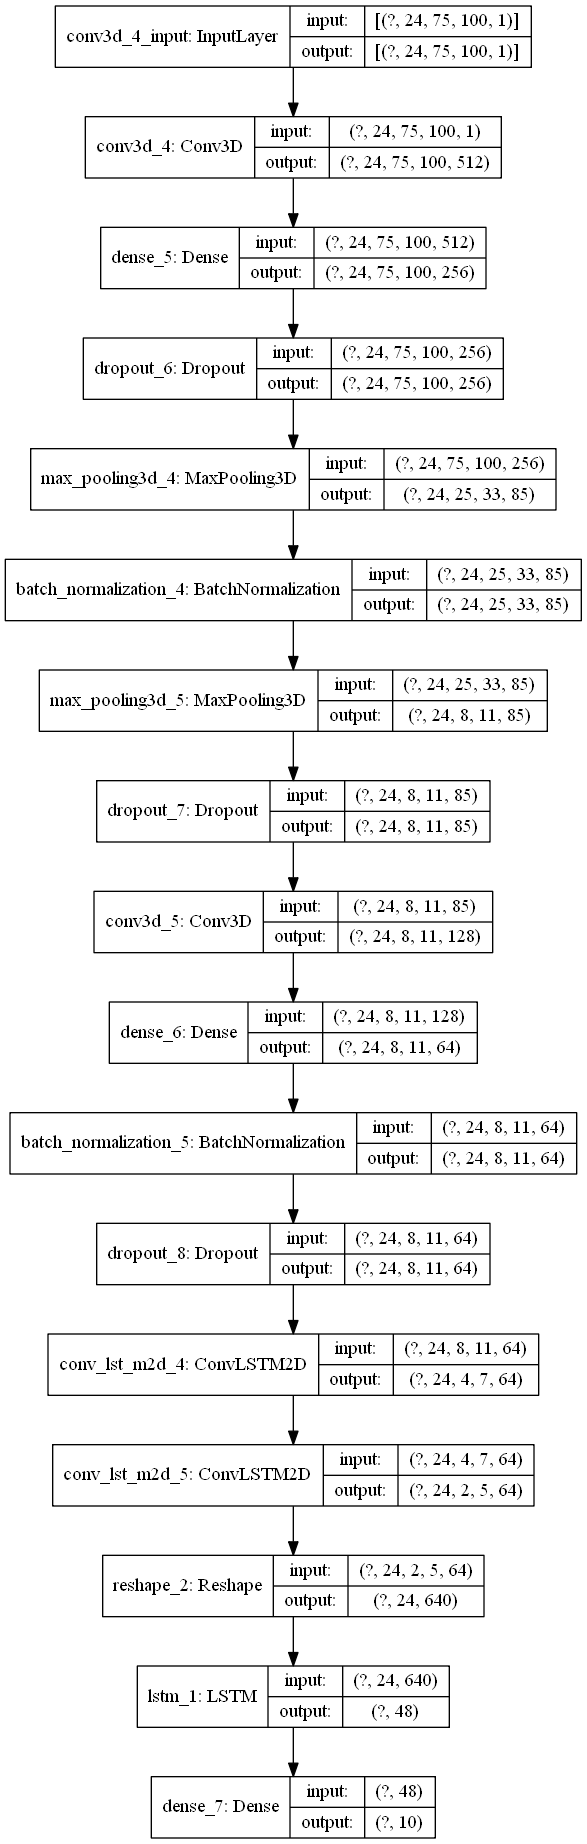

In [84]:
plot_name = folder + '\\images\\' +modele_type + param + '_plot.png'
plot_model(model, to_file = plot_name, show_shapes=True, show_layer_names=True)

In [85]:
#Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

##### Chargement d'un modele préentrainé (par nous même)

In [86]:
#model_stolen_saved = keras.models.load_model('Saved_model\\modele_stolen_compile')

## Generator

In [87]:
def homemade_fit_gen_thread(model, labels_val,pack_size,epochs,batch_size,fps = 5,size = (160,120)):
    '''
    Charge les données à partir du csv labels_val et train le model avec
    les différents paramètres
    Le model est train.
    
    Si besoin, return de X,y et model (mais normalement le model original est train)
    '''
#     q = Queue()
    
    #Histories de train ou de batch_loss au choix 
    histories = []
    
    t = threading.Thread(target = gen_thread, daemon = True,#Daemon afin que le thread s'arrête avec le thread principal
                        args = ((labels_val, "DATA\\Videos",pack_size,fps, size))) 
    t.start()
    while True:
        X, y_num = q.get()
        print("I got the pack! I'm going to fit it")
        print()
        #Catégorisation pour train
        y = to_categorical(y_num, num_classes = nb_classes)
        
        start_fit = time()
#       batch_loss = model.train_on_batch(X,y)
        history = model.fit(X, y,
                batch_size = batch_size,
                epochs=epochs,
                verbose=1,
                validation_split=0.1)  #Dans le fond je m'en fous un peu de cb je prend pour test
        end_fit = time()
        
        #histories.append(batch_loss)
        histories.append(history)
        print(f"J'ai fini de train le paquet, ça m'a prit {end_fit - start_fit} secondes")
        q.task_done() #Jsp si c'est utile
        
        #Il faut que le fit prenne plus de temps que le chargement des vidéos, sinon ça va pas aller
        
        if q.empty():
            print("J'ai peut-être fini, j'attends encore qq sec pour être sur d'avoir bien fini")
            sleep(20) #Je m'assure que c'est vraiment bien fini
            if q.empty():
                print("J'ai vraiment fini")
                break
            else:
                print("Je n'avais pas fini en fait")
    
    t.join() #Je m'assure que le thread soit bien fini. 
    #Si il n'est pas fini, on plante. S'il avait fini, alors ça ne servait à rein
    
    del X
    del y
    del y_num
    
    return model, histories

In [88]:
def homemade_fit_gen(model, labels_val,pack_size,epochs,batch_size,fps = 5,size = (160,120)):
    '''
    Charge les données à partir du csv labels_val et train le model avec
    les différents paramètres
    Le model est train.
    
    my_gen et fit tournent en parallèle grâce à un thread
    Si besoin, return de X,y et model (mais normalement le model original est train)
    '''
    
    histories = []
    
    pointer = 0
    can_continue = True
    
    while can_continue:
        X, y_num, pointer = my_gen(labels_val, "DATA\\Videos",pack_size = pack_size,fps = fps, size = size, pointer = pointer)
        
        #Catégorisation pour train
        y = to_categorical(y_num, num_classes = nb_classes)
        
        if pointer >= len(labels_val):
            can_continue = False
        print()

        #print('vidéos chargées, shape:',X.shape,'. y len : ',len(y_num)) #DEBUG
#         with tf.device('cpu:0'):
#             history = model.fit(X, y,
#                     batch_size = batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.2,
#                     callbacks = [tensorboard])
#         histories.append(history)
        
        #Suppression des variables qui ne sont plus utiles pour libérer de la mémoire
        del X
        del y
        del y_num
    return model, histories

## Import des données et traitement

In [115]:
#Import des labels
labels_csv = pd.read_csv("DATA\\labels.csv")
labels_name = pd.read_csv("DATA\\labels_uses.csv")
labels_tests_csv = pd.read_csv("DATA\\labels_tests.csv")

In [116]:
#Créé un dictionnaire qui associe le nom du label et un numérique afin de le mettre dans le modele
labels_n = {}
for i,label in enumerate(labels_name.values):
    labels_n[label[0]] = i
    labels_n[i] = label[0]

    
#Trier les labels pour ne prendre que ceux qui correspondent à labels_uses
labels = []
for label, video_name in labels_csv.values:
    if label in labels_n:
        labels.append((label,video_name))

#Idem pour le label de tests
labels_tests = []
for label, video_name in labels_tests_csv.values:
    if label in labels_n:
        labels_tests.append((label,video_name))


#Melange la liste de train
for j in range(5):
    random.shuffle(labels) #Il faut absolument shuffle pour train

In [117]:
#Count de chaque label
labels_c = {}
for label in labels_name.values:
    labels_c[label[0]] = 0

for label,video_name in labels:
    if label in labels_c:
        labels_c[label] += 1

print(labels_c)

{'Ferme le poing': 134, 'Ouvre le poing': 134, 'Clap': 134, 'Swipe gauche main droite': 134, 'Swipe droit main gauche': 134, 'Doigts croises paumes': 134, 'Explosion avec les doigts ouverts': 134, 'Ouvrir un livre avec le poing ferme main D': 134, 'Ouvrir un livre avec le poing ferme main G': 134, 'Faire coucou': 134}


## Train

In [92]:
q = Queue(maxsize = 1) #Variable globale nécessaire pour le bon fonctionnement du gen en thread

In [93]:
if model_charge:
    print('Il ne faut pas train le modele car il a déjà été chargé')
else:
    print('Il faut entrainer le modele')
    start = time()
    model, histories = homemade_fit_gen_thread(model, labels, pack_size = pack_size,
                                                    epochs = epochs,batch_size = batch_size,
                                                    fps = fps, size = size)
    end = time()
    print(f"ça a prit {end-start} secondes d'entrainer le modele")

Il faut entrainer le modele

Pack of 50 videos put in queueI got the pack! I'm going to fit it


Epoch 1/2

Pack of 50 videos put in queue
5/5 [==============================] - 182s 36s/step - loss: 2.3754 - accuracy: 0.0889 - val_loss: 2.5107 - val_accuracy: 0.0000e+00
Epoch 2/2
5/5 [==============================] - 167s 33s/step - loss: 1.7695 - accuracy: 0.4889 - val_loss: 2.2466 - val_accuracy: 0.0000e+00
J'ai fini de train le paquet, ça m'a prit 472.68088698387146 secondes
I got the pack! I'm going to fit it

Pack of 50 videos put in queue
Epoch 1/2

5/5 [==============================] - 165s 33s/step - loss: 1.8478 - accuracy: 0.3333 - val_loss: 1.7876 - val_accuracy: 0.4000
Epoch 2/2
5/5 [==============================] - 164s 33s/step - loss: 1.2419 - accuracy: 0.7556 - val_loss: 1.7037 - val_accuracy: 0.2000
J'ai fini de train le paquet, ça m'a prit 425.2632610797882 secondes
Pack of 50 videos put in queue
I got the pack! I'm going to fit it

Epoch 1/2

5/5 [===============

### Amélioration du graphes au fur et à mesure du temps

In [94]:
#Pour l'histories de fit
if not model_charge:
    acc_plot = [hist.history['accuracy'] for hist in histories]
    loss_plot = [hist.history['loss'] for hist in histories]
    val_acc_plot = [hist.history['val_accuracy'] for hist in histories]
    val_loss_plot = [hist.history['val_loss'] for hist in histories]

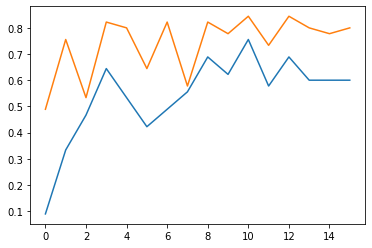

In [95]:
if not model_charge: plt.plot(acc_plot)

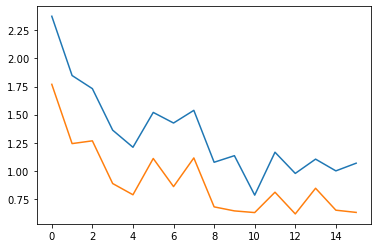

In [96]:
if not model_charge: plt.plot(loss_plot)

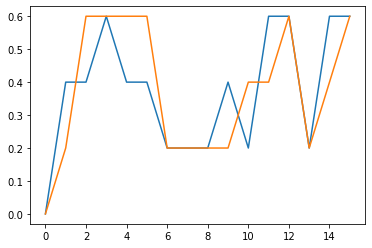

In [97]:
if not model_charge: plt.plot(val_acc_plot)

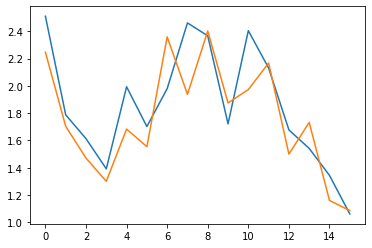

In [98]:
if not model_charge: plt.plot(val_loss_plot)

## Tests

In [118]:
X_test, y_test, _ = my_gen(labels_tests, "DATA\\V_tests",pack_size = 1000,fps = fps, size = size)
#Grand pack_size afin de prendre toutes les données

In [119]:
y_pred = model.predict(X_test)

## Affichage d'une video avec la prédiction pour comprendre si le résultat est justifié ou non

original: Ouvrir un livre avec le poing ferme main D
prediction: Ouvrir un livre avec le poing ferme main D


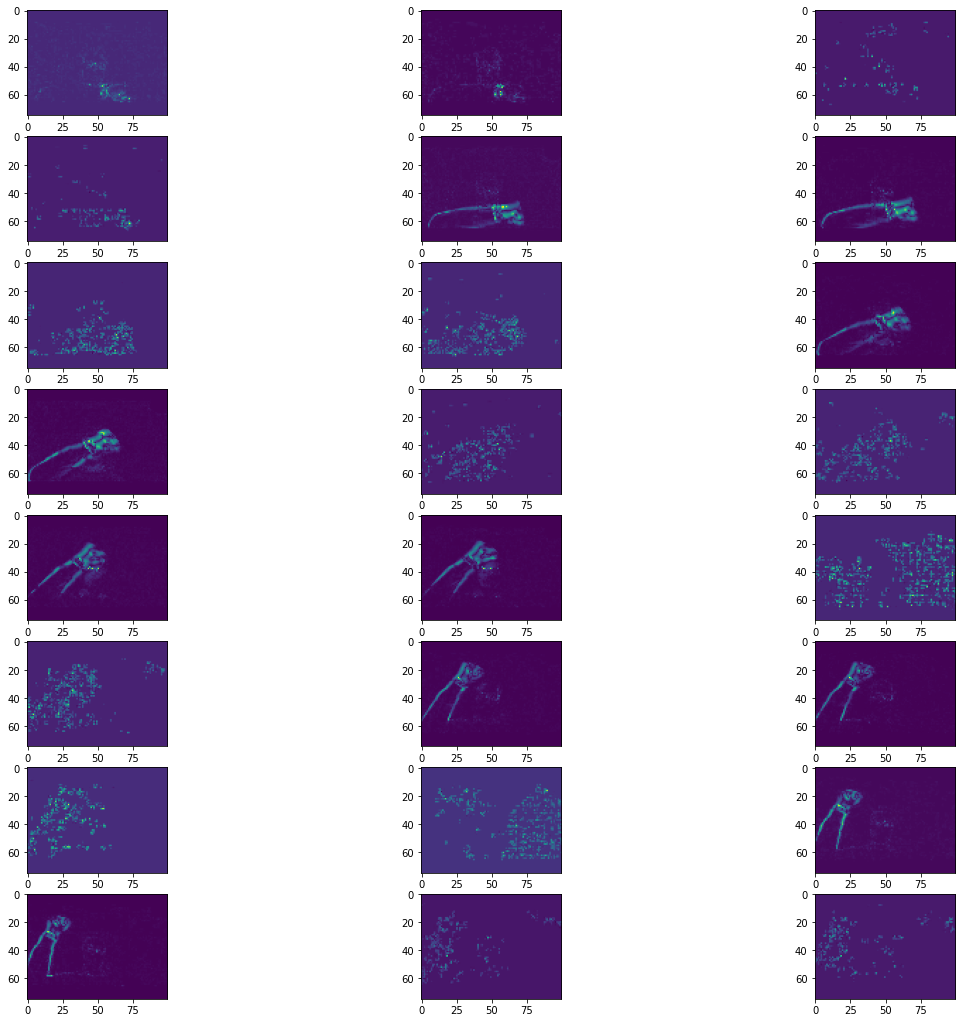

In [120]:
plt.figure(figsize=(20,60)) #(20,60) pour des images en (120,160). (20,180) pour des images en (480,640)
#print(X_test.shape)
#Visu des mouvements avec une petite size (en fonction des paramètres initiaux)
columns = 3
vid_a_test = 11
print("original:",labels_n[y_test[vid_a_test]])
print("prediction:",labels_n[y_pred[vid_a_test].argmax()])
for i, img in enumerate(X_test[vid_a_test]):
    plt.subplot(int(len(img) / columns + 1), columns, i + 1)
    plt.imshow(img)

### visualisation des  résultats

In [121]:
import fidle.pwk as pwk

In [122]:
full_name

'Saved_model\\model_convLSTM2D_10_75_100_10_2_10_50_1mili'

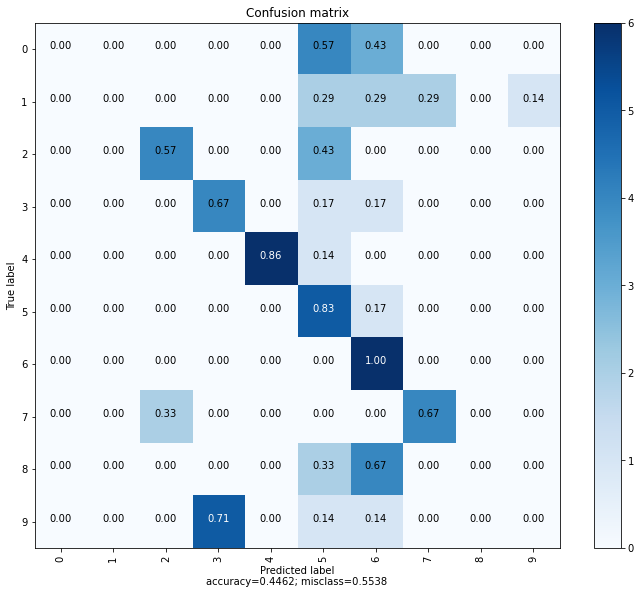

In [123]:
y_pred_arg = np.argmax(y_pred, axis=-1)
plot_confusion_name = full_name + '_confusion.png'
cfm_plot = pwk.plot_confusion_matrix(y_test,y_pred_arg,range(nb_classes),normalize=True)

In [124]:
y_test_cat = to_categorical(y_test,10)
score = model.evaluate(X_test, y_test_cat, verbose=1)

print('Test loss     :', score[0])
print('Test accuracy :', score[1])

3/3 [==============================] - 101s 34s/step - loss: 1.7926 - accuracy: 0.4462
Test loss     : 1.7926281690597534
Test accuracy : 0.446153849363327


In [127]:
#y_pred

In [129]:
#On vérifie que les résultats sont normalisé
for result in y_pred:
    #print('la somme est:',sum(result))
    pass

In [130]:
print(labels_n)

{'Ferme le poing': 0, 0: 'Ferme le poing', 'Ouvre le poing': 1, 1: 'Ouvre le poing', 'Clap': 2, 2: 'Clap', 'Swipe gauche main droite': 3, 3: 'Swipe gauche main droite', 'Swipe droit main gauche': 4, 4: 'Swipe droit main gauche', 'Doigts croises paumes': 5, 5: 'Doigts croises paumes', 'Explosion avec les doigts ouverts': 6, 6: 'Explosion avec les doigts ouverts', 'Ouvrir un livre avec le poing ferme main D': 7, 7: 'Ouvrir un livre avec le poing ferme main D', 'Ouvrir un livre avec le poing ferme main G': 8, 8: 'Ouvrir un livre avec le poing ferme main G', 'Faire coucou': 9, 9: 'Faire coucou'}


In [131]:
#Je peux afficher l'historique de chaque étape (je n'ai aps réussi à les faire fusionner)
#On ne peut afficher que si on a train

#history = histories[-1]
#pwk.plot_history(history, figsize=(6,4), save_as='03-history')

## Enregistrer le modèle

In [132]:
#Le nom est fabriqué en début de notebook

In [111]:
#Enregistrement du résultat dans le csv

In [112]:
def write_score(model_name,score):
    labels = open("Saved_model\\score.csv","a") #append
    labels.write("\n" + model_name + "," + "{:10.8f}".format(score[0]) + "," + "{:10.8f}".format(score[1]))
    #Ajoute une nouvelle info sur une nouvelle ligne
    labels.close()

In [113]:
print(full_name)

Saved_model\model_convLSTM2D_10_75_100_10_2_10_50_1mili


In [114]:
# LSTM, 5 FPS, Height = 60, Width = 80, nb_Classes = 10, 3 Epochs, Batch_size = 10, Pack_size = 50, learning_rate *1000
if not model_charge: #On ne doit charger le modele que si il a été train cette fois-ci
    write_score(full_name,score)
    model.save(full_name+".h5")